In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [29]:
class Inputs_TwoDots():
    def __init__(self, dt=0.001, dt_sample=None, seed=0):
        self.coherence = None  # motion strength: 0=equal in two directions, 1=entirely one direction
        self.L = None  # percent of dots moving left on this trial
        self.R = None  # percent of dots moving right on this trial
        self.correct = None  # predominant direction of motion for this trial
        self.dt = dt  # nengo timestep
        self.dt_sample = dt_sample  # periodically resample the environment using a noisy perceptual system
        self.dL = None  # currently sampled fraction of dots moving left
        self.dR = None  # currently sampled fraction of dots moving right
        self.rng = np.random.RandomState(seed=seed)
    def create(self, coherence):
        assert 0 <= coherence <= 1
        self.coherence = coherence
        self.dL = 0
        self.dR = 0
        self.correct = "L" if self.rng.rand() < 0.5 else "R"
        if self.correct == "L":
            self.L = 0.5 + self.coherence/2
            self.R = 0.5 - self.coherence/2
        if self.correct == "R":
            self.L = 0.5 - self.coherence/2
            self.R = 0.5 + self.coherence/2
        assert self.L + self.R == 1
    def sample(self, t):
        if self.dt_sample is not None:  # noisy perceptual sampling process
            if t % self.dt_sample < self.dt:
                self.dL = 1 if self.rng.rand() < self.L else 0
                self.dR = 1 if self.rng.rand() < self.R else 0
            return [self.dL, self.dR]
        else:  # directly perceive coherence level
            return [self.L, self.R]

In [4]:
def build_network(inputs, nNeurons=1000, synapse=0.1, seed=0, ramp=1, threshold=1, relative=0):
    
    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.03
    net.config[nengo.Probe].synapse = 0.03

    # references
    net.inputs = inputs
    net.seed = seed
    net.synapse = synapse
    net.nNeurons = nNeurons

    net.ramp = ramp
    net.threshold = threshold
    net.relative = relative

    func_input = lambda t: net.inputs.sample(t)
    func_threshold = lambda t: net.threshold
    func_ramp = lambda x: net.synapse * net.ramp * x
    func_value = lambda x: [x[0]-x[1]*net.relative, x[1]-x[0]*net.relative]  # raw evidence vs relative advantage
    
    ePos = nengo.dists.Choice([[1]])
    iPos = nengo.dists.Uniform(0.01, 1)

    with net:
        # Inputs
        environment = nengo.Node(func_input)
        threshold = nengo.Node(func_threshold)
        # Ensembles
        perception = nengo.Ensemble(nNeurons, 2)
        accumulator = nengo.Ensemble(nNeurons, 2)
        value = nengo.Ensemble(nNeurons, 2)
        gate = nengo.Ensemble(nNeurons, 1, encoders=ePos, intercepts=iPos)
        action = nengo.networks.EnsembleArray(nNeurons, 2, encoders=ePos, intercepts=iPos)
        # Connections
        nengo.Connection(environment, perception)  # external inputs
        nengo.Connection(perception, accumulator, synapse=net.synapse, function=func_ramp)  # send percepts to accumulator
        nengo.Connection(accumulator, accumulator, synapse=net.synapse) # recurrent connection for accumulation
        nengo.Connection(accumulator, value, function=func_value)  # compute value from evidence in accumulator
        nengo.Connection(value, action.input)
        nengo.Connection(threshold, gate)  # external inputs
        nengo.Connection(gate, action.input, transform=[[-1], [-1]])  # inhibition via decision criteria
        # Probes
        net.pInputs = nengo.Probe(environment)
        net.pPerception = nengo.Probe(perception)
        net.pAccumulator = nengo.Probe(accumulator)
        net.pValue = nengo.Probe(value)
        net.pGate = nengo.Probe(gate)
        net.pAction = nengo.Probe(action.output)

    return net

In [5]:
def run_until_choice(coherence, seed1=0, seed2=0, dt=0.001, dt_sample=None, legend=False, name="revised", **kwargs):
    inputs = Inputs_TwoDots(dt_sample=dt_sample, seed=seed1)
    inputs.create(coherence=coherence)
    net = build_network(inputs, seed=seed2, **kwargs)
    sim = nengo.Simulator(net, progress_bar=False)
    choice = None
    while choice==None:
        sim.run(dt)
        if sim.data[net.pAction][-1,0] > 0:
            choice = "L"
            RT = sim.trange()[-1]
        elif sim.data[net.pAction][-1,1] > 0:
            choice = "R"
            RT = sim.trange()[-1]
        if sim.trange()[-1] > 10:
            break
    is_correct = True if choice==inputs.correct else False
    idealL = sim.trange()/dt * net.inputs.L * net.ramp * dt
    idealR = sim.trange()/dt * net.inputs.R * net.ramp * dt

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7.08, 4)))
    axes[0].plot(sim.trange(), sim.data[net.pAccumulator][:,0], color=palette[0], label="evidence L") 
    axes[0].plot(sim.trange(), sim.data[net.pAccumulator][:,1], color=palette[1], label='evidence R') 
    if dt_sample is not None:
        axes[0].plot(sim.trange(), idealL, color=palette[0], label="true L", linestyle="--") 
        axes[0].plot(sim.trange(), idealR, color=palette[1], label='true R', linestyle="--") 
    axes[1].plot(sim.trange(), sim.data[net.pValue][:,0], color=palette[0], label="value L") 
    axes[1].plot(sim.trange(), sim.data[net.pValue][:,1], color=palette[1], label='value R') 
    axes[1].plot(sim.trange(), sim.data[net.pGate], label='threshold', color=palette[4])
    axes[0].set(ylabel=r"$\mathbf{\hat{x}}(t)$", title="Evidence in Accumulator")
    axes[1].set(xlabel="Time (s)", ylabel=r"$\mathbf{\hat{x}}(t)$", title="Decision Criteria")
    
    if legend:
        axes[0].legend(loc='upper left', ncol=2)
        leg = axes[1].legend(loc='upper left', ncol=1)
        if choice=="L":
            leg.get_texts()[0].set_color("lime" if is_correct else "red")
        if choice=="R":
            leg.get_texts()[1].set_color("lime" if is_correct else "red")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

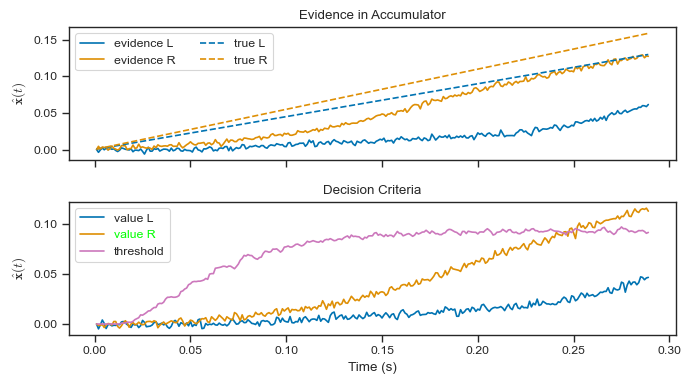

In [19]:
run_until_choice(coherence=0.1, threshold=0.1, seed1=0, dt_sample=0.01, legend=True)

In [46]:
def scan_coherence(coherences=np.geomspace(0.008, 0.512, 7),
                   trials_per_coherence=3,
                   perception_seed=0,
                   network_seed=0,
                   dt=0.001,
                   dt_sample=0.01,
                   ramp=1,
                   threshold=0.5,
                   relative=0):
    
    inputs = Inputs_TwoDots(dt_sample=dt_sample, seed=perception_seed)
    inputs.create(coherence=coherences[0])
    net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative)

    columns = ('trial', 'coherence', 'RT', 'correct')
    dfs = []
    for coherence in coherences:
        for trial in range(trials_per_coherence):
            inputs.create(coherence=coherence)
            sim = nengo.Simulator(net, progress_bar=False)
            choice = None
            while choice==None:
                sim.run(dt)
                if sim.data[net.pAction][-1,0] > 0:
                    choice = "L"
                    RT = sim.trange()[-1]
                elif sim.data[net.pAction][-1,1] > 0:
                    choice = "R"
                    RT = sim.trange()[-1]
                elif sim.trange()[-1] > 5:
                    choice = "L" if sim.data[net.pValue][-1,0] > sim.data[net.pValue][-1,1] else "R"
                    RT = sim.trange()[-1]
            correct = True if choice==inputs.correct else False
            print(coherence, RT, correct)
            dfs.append(pd.DataFrame([[trial, coherence, RT, correct]], columns=columns))
    data = pd.concat(dfs, ignore_index=True)
    
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7.08, 4)))
    sns.lineplot(data=data, x='coherence', y='RT', ax=axes[0])
    sns.lineplot(data=data, x='coherence', y='correct', ax=axes[1])
    plt.xscale('log')
    plt.tight_layout()

0.008 1.048 True
0.008 1.18 False
0.008 0.993 True
0.008 1.028 True
0.008 1.072 False
0.008 1.177 True
0.008 0.9530000000000001 True
0.008 0.9540000000000001 False
0.008 1.0070000000000001 False
0.008 1.053 True
0.008 1.073 False
0.008 1.22 True
0.008 1.229 False
0.008 1.0090000000000001 False
0.008 1.444 False
0.008 1.047 False
0.008 1.204 False
0.008 1.073 True
0.008 0.973 False
0.008 1.183 False
0.008 1.204 True
0.008 0.932 True
0.008 1.107 False
0.008 1.227 False
0.008 1.067 True
0.008 0.9590000000000001 True
0.008 0.992 True
0.008 0.965 False
0.008 1.124 False
0.008 1.025 True
0.016000000000000007 1.032 True
0.016000000000000007 1.127 False
0.016000000000000007 1.078 False
0.016000000000000007 1.0130000000000001 False
0.016000000000000007 1.073 False
0.016000000000000007 1.0030000000000001 True
0.016000000000000007 0.885 True
0.016000000000000007 1.074 True
0.016000000000000007 1.08 True
0.016000000000000007 1.094 False
0.016000000000000007 1.0030000000000001 True
0.01600000000000

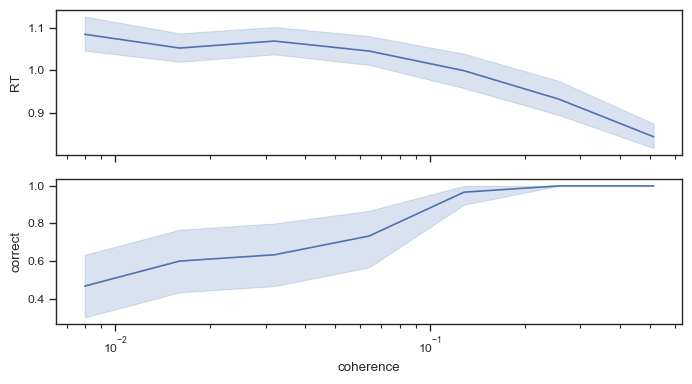

In [48]:
scan_coherence(trials_per_coherence=30, dt_sample=0.02, threshold=0.5)